#imports

In [ ]:
!pip install emoji

     |████████████████████████████████| 51kB 1.9MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=8160bdc79daab6a43271e21dad14059800c701899dd39e22f4227634a8d37e59
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import tensorflow as tf

import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
import emoji

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras import layers
from keras import regularizers

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
drive.mount("/content/drive/", force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
##################################################
# Utils
##################################################

def label_to_emoji(label):
    """
    Converts a label (int or string) into the corresponding emoji code (string) ready to be printed
    """
    return emoji.emojize(emoji_dictionary[str(label)], use_aliases=True)

In [ ]:
# PATHS FLA

PATH_TRAIN = "/content/drive/My Drive/Unipd/ML Project/data/train.npy"
PATH_TEST = "/content/drive/My Drive/Unipd/ML Project/data/validation.npy"

PATH_TRAIN_CSV = "/content/drive/My Drive/Unipd/ML Project/data/train.csv"
PATH_VALID_CSV = "/content/drive/My Drive/Unipd/ML Project/data/validation.csv"

PATH_TEST1 = "/content/drive/My Drive/Unipd/ML Project/data/test.npy"

PATH_SUBMISSION = "/content/drive/My Drive/Unipd/ML Project/data/sample_submission_ok.csv"
PATH_TEST_CSV = "/content/drive/My Drive/Unipd/ML Project/data/sample_submission.csv"

In [ ]:
# PATHS MARCO

PATH_TRAIN = "/content/drive/My Drive/data/train.npy"
PATH_TEST = "/content/drive/My Drive/data/validation.npy"

PATH_TRAIN_CSV = "/content/drive/My Drive/data/train.csv"
PATH_VALID_CSV = "/content/drive/My Drive/data/validation.csv"

PATH_TEST1 = "/content/drive/My Drive/data/test.npy"
PATH_TEST_CSV = "/content/drive/My Drive/data/sample_submission.csv"

# Load training & validation data

In [ ]:
##################################################
# Load dataset
##################################################

df_train = pd.read_csv(PATH_TRAIN_CSV)
y_train = df_train['class']
df_validation = pd.read_csv(PATH_VALID_CSV)
y_validation = df_validation['class']
emoji_dictionary = {
    '0': '\u2764\uFE0F',
    '1': ':baseball:',
    '2': ':smile:',
    '3': ':disappointed:',
    '4': ':fork_and_knife:'
}

# See some data examples
print('EXAMPLES:\n####################')
for idx in range(10):
    print(f'{df_train["phrase"][idx]} -> {label_to_emoji(y_train[idx])}')

EXAMPLES:
####################
I want to go play -> ⚾
I want to have sushi for dinner -> 🍴
I am always working -> 😞
she is happy -> 😄
What is wrong with you -> 😞
I am proud of your achievements -> 😄
funny -> 😄
do you like pizza  -> 🍴
no one likes him -> 😞
he is the best player -> ⚾


In [ ]:
# Load phrase representation
x_train = np.load(PATH_TRAIN).reshape(len(df_train), -1)
x_validation = np.load(PATH_TEST).reshape(len(df_validation), -1)
print(f'Word embedding size: {x_train.shape[-1]}')

Word embedding size: 250


In [ ]:
# create complete dataset for k-fold cv
x_complete = np.vstack((x_train, x_validation))
y_complete = np.hstack((y_train.values, y_validation))

## Classes distribution on TS & VS

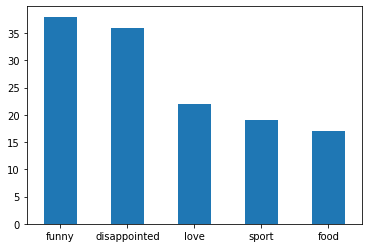

In [ ]:
_ = pd.concat((df_train, df_validation),
              ignore_index = True)["class"].value_counts().plot.bar()
_ = plt.xticks(ticks = [0, 1, 2, 3, 4],
               labels = ["funny", "disappointed", "love", "sport", "food"],
               rotation = 0)
_ = plt.savefig("./EDA.png", dpi = 200)

## Remove stopwords

In [ ]:
# find what are the stopword in our corpus, according to the standard
# stopword list by scikit-learn
# exploit the vocabulary from tfidf vectorizer,
# one constructed considering stopwords and the other without them
vectorizer = TfidfVectorizer()
vectorizer_nostop = TfidfVectorizer(stop_words = 'english')

corpus = pd.concat((df_train, df_validation), ignore_index = True) 

vectorizer.fit(corpus["phrase"])
vectorizer_nostop.fit(corpus["phrase"])

words_nostop = set(vectorizer_nostop.vocabulary_.keys())
words_stop = set(vectorizer.vocabulary_.keys())
stopwords = words_stop - words_nostop
stopwords.add('i')
stopwords.add('it')
stopwords.add('the')
stopwords.add('a')
stopwords.add('did')
stopwords.add('lot')
stopwords.add('got')

In [ ]:
# stopwords should now be the set of stopwords in our phrases
# we will probably want to take a look at it to keep words such as
# "like" or "really" or "not" which may be stopwords but we may want to keep
# since we are insterested in the polarity of a statement and not only about
# its topic.

print(len(stopwords))
# if necessary, remove some word
stopwords = stopwords - {'again', 'such', 'no', 'never', 'cannot', 'alone', 'will', 'together', 'well',
              'down', 'ever', 'very', 'give', 'can', 'many', 'much', 'but',
              'not', 'always', 'few', 'up', 'anything', 'some', "made", "we"}
print(len(stopwords))
print(stopwords)

80
55
{'her', 'too', 'got', 'am', 'see', 'this', 'after', 'have', 'one', 'my', 'so', 'of', 'get', 'where', 'by', 'she', 'the', 'go', 'me', 'do', 'us', 'were', 'to', 'and', 'that', 'has', 'an', 'with', 'your', 'a', 'it', 'him', 'was', 'they', 'on', 'how', 'though', 'did', 'two', 'had', 'here', 'lot', 'you', 'in', 'i', 'is', 'at', 'for', 'could', 'first', 'he', 'are', 'who', 'what', 'when'}


In [ ]:
# we now want to assign a 0 vector to the word embeddings corresponding to the stopwords

x_train_words = np.load(PATH_TRAIN)
x_validation_words = np.load(PATH_TEST)

corpus_vectors = np.vstack((x_train_words, x_validation_words))

# for each document in the corpus
for doc_indx in range(len(corpus)):
  # for each word in the document
  for word_indx, word in enumerate(corpus["phrase"][doc_indx].split()):
    # if the word is in the vocabulary
    if word.lower() in stopwords:
      # assign zero to its correspondent vector
      corpus_vectors[doc_indx][word_indx] = 0

In [ ]:
# now, we want to remove the zero vectors we left inside the phrases

for doc_indx in range(len(corpus)):
  # create a version of the document with only non-negative coordinates,
  # preserving the order
  mask = np.array([x.any() for x in corpus_vectors[doc_indx]])
  num_elem = mask.sum()
  new_doc = np.zeros((10, 25))
  new_doc[:num_elem] = corpus_vectors[doc_indx][mask]
  corpus_vectors[doc_indx] = new_doc

In [ ]:
# create complete version of the dataset without stopwords
x_complete_nostop = corpus_vectors.reshape(132, -1)
x_complete_nostop.shape

(132, 250)

# Standardizer

In [ ]:
class StdTransformer(BaseEstimator, TransformerMixin):
  
  def __init__(self):
    self._mean = None
    self._std = None
    self._scaler = StandardScaler()

  def fit(self, X, y = None):
    
    rows_phrases = X.shape[0]

    x_3d = X.reshape((rows_phrases, 10, 25))

    all_phrases = np.zeros((1, 25))

    for doc_indx, document in enumerate(x_3d):
      for word_indx, word in enumerate(document):
        if np.linalg.norm(word) != 0:
          all_phrases = np.vstack((all_phrases, word))
    
    # remove first row of zeros
    all_phrases = all_phrases[1:]
    # fit the scaler on all_phrases
    self._scaler.fit(all_phrases)
    # compute the mean and the std on all_phrases
    self._mean = self._scaler.mean_
    self._std = self._scaler.scale_

    return self
    
  def transform(self, X, y = None):
    
    # create a copy of X?
    X_trans = X.copy()
    
    rows_phrases = X.shape[0]

    x_3d = X_trans.reshape((rows_phrases, 10, 25))

    for doc_indx, document in enumerate(x_3d):
      for word_indx, word in enumerate(document):
        if np.linalg.norm(word) != 0:
          x_3d[doc_indx][word_indx] = (x_3d[doc_indx][word_indx] - self._mean)/self._std
    
    X_trans = x_3d.reshape(rows_phrases, 250)

    return X_trans

# Load test data

In [ ]:
df_test = pd.read_csv(PATH_TEST_CSV)
df_test["phrase"] = df_test["phrase"].map(lambda x: x.replace("\n", ""))
x_test = np.load(PATH_TEST1)

## Remove stopwords

In [ ]:
# remove stopwords from test dataset
x_test_nostop = np.copy(x_test)

# for each document in the corpus
for doc_indx in range(len(df_test)):
  # for each word in the document
  for word_indx, word in enumerate(df_test["phrase"][doc_indx].split()):
    # if the word is in the vocabulary
    if word.lower() in stopwords:
      # assign zero to its correspondent vector
      x_test_nostop[doc_indx][word_indx] = 0

In [ ]:
# now, we want to remove the zero vectors we left inside the phrases

for doc_indx in range(len(df_test)):
  # create a version of the document with only non-negative coordinates,
  # preserving the order
  mask = np.array([x.any() for x in x_test_nostop[doc_indx]])
  num_elem = mask.sum()
  new_doc = np.zeros((10, 25))
  new_doc[:num_elem] = x_test_nostop[doc_indx][mask]
  x_test_nostop[doc_indx] = new_doc

# Utils

## Plot grid search learning curve

In [ ]:
def grid_search_lc(model, varying_param, fixed_params, x, y, n_folds, hline,
                   scoring_metric = 'accuracy', show_variance = False):
  """This function is a variation to the classic grid search which allows to
  compare different parameters using learning curves plotted for each parameter.

  model : class
    This should be a model class.
  
  fixed_params : dict
    A dictionary containing all unvaried but chosen parameters for the model.

  varying_params : list
    This should be a list of dictionaries, each containing a parameter value
    one wants the model to run with and compare to other values
    by looking at the learning curves.

  scoring_metric : str
    Should take a value among: 'accuracy', 'neg_mean_absolute_error',
    'neg_mean_squared_error', and other error metrics in 
    sklearn.metrics.SCORERS.keys().

  hline : list
    A list of booleans indicating whether to plot an horizontal line to indicate
    the estimated value of convegence of the scoring metric on training and
    test set.

  show_variance : bool
    Indicates whether to show the variance of the scoring metric computed
    over the folds. 
  """
  
  cmap = plt.get_cmap("tab10")
  legend = []

  _ = plt.subplots(1, figsize = (8, 6))

  for i, param_setting in enumerate(varying_param):
    setting = fixed_params
    
    varying_param = list(param_setting)[0]
    varying_param_value = param_setting[varying_param]
    
    # adding the varying parameter to the model configuration
    setting[varying_param] = varying_param_value

    # updating plot legend
    legend.append(varying_param_value)
    legend.append(varying_param_value)

    model_instance = model(**setting)

    pipe_list = [('std_trans', StdTransformer()), ('clf', model_instance)]
    pipe = Pipeline(pipe_list)

    upper_range = len(x) - len(x)//n_folds

    stratCV = StratifiedKFold(n_splits = n_folds, shuffle = True)

    train_sizes, train_scores, valid_scores = \
    learning_curve(pipe, x, y, train_sizes=range(6, upper_range, 2), 
                   scoring = scoring_metric,
                   cv = stratCV)
    
    # computing means over folds
    valid_mean =  valid_scores.mean(axis = 1)
    valid_std =  valid_scores.std(axis = 1)
    train_mean =  train_scores.mean(axis = 1)
    train_std =  train_scores.std(axis = 1)

    _ = plt.plot(train_sizes, valid_mean, linestyle = "dashed", color = cmap(i))
    _ = plt.plot(train_sizes, train_mean, color = cmap(i))
    
    if hline[i]:
      _ = plt.hlines((train_mean[-1] + valid_mean[-1])/2, 0, 120,
                     color = cmap(i), linestyles="dashed", linewidth = 1)

    if show_variance:
      _ = plt.fill_between(train_sizes, 
                          valid_mean + valid_std, 
                          valid_mean - valid_std,
                          color = cmap(i), alpha = 0.1)

      _ = plt.fill_between(train_sizes, 
                          train_mean + train_std, 
                          train_mean - train_std,
                          color = cmap(i), alpha = 0.1)
    
    #lgd = plt.legend(legend, bbox_to_anchor = (1, 0.5))
    _ = plt.legend(legend)
    _ = plt.ylabel(scoring_metric)
    _ = plt.xlabel("# Training samples")

## Plot CV history

In [ ]:
def plot_cv_history(train_acc, val_acc, train_loss, val_loss, run, param_label, loss = True):
  """Plots learning curves using loss or accuracy values averaged after
k-fold CV.
  """
  cmap = plt.get_cmap("tab10")
  x = range(1, len(train_acc) + 1)

  if loss:
    plt.plot(x, train_loss, color = cmap(run), label = param_label)
    plt.plot(x, val_loss, color = cmap(run), label = param_label, linestyle="dashed")
    plt.title('Training and validation loss')
    plt.legend()

  else: 
    plt.plot(x, train_acc, color = cmap(run), label = param_label)
    plt.plot(x, val_acc, color = cmap(run), label = param_label, linestyle="dashed")
    plt.title('Training and validation accuracy')
    plt.legend()

## Plot CV heatmap

In [ ]:
def CV_heatmap(model, n_folds, data = x_complete_nostop):
  """Performs k-fold cross validation. Optionally, plots averaged confusion
  matrix using plot_cm = {'True', 'False'} 
  """
  k_fold = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state=32)

  avg_accuracy = 0

  transformer = StdTransformer()

  conf_matrix = np.zeros((5, 5))

  for train_index, test_index in k_fold.split(data, y_complete):
    x_train, x_validation = data[train_index], data[test_index]
    y_train, y_validation = y_complete[train_index], y_complete[test_index]

    # transform train and validation data to standardized form
    transformer.fit(x_train)
    x_train = transformer.transform(x_train)
    x_validation = transformer.transform(x_validation)

    model.fit(x_train, y_train)
    
    model_predictions = model.predict(x_validation)

    accuracy = accuracy_score(model_predictions, y_validation)*100

    conf_matrix += confusion_matrix(y_validation, model_predictions, 
                                      labels = [0, 1, 2, 3, 4])

    print("Accuracy Score ->", accuracy)
    avg_accuracy += accuracy
    
  
  print(f"Average accuracy over {n_folds} folds: {avg_accuracy/n_folds}")

  
  #conf_matrix /= n_folds

  labels = ["love", "sport", "funny", "disappointed", "food"]
  _ = sns.heatmap(conf_matrix,
                  annot = True, square = 1, cmap = sns.light_palette("green"),
                  xticklabels = labels, yticklabels = labels)
  _ = plt.xlabel("Predicted label")
  _ = plt.ylabel("True label")
  _ = plt.savefig("./" + str(type(model)) + "_heatmap.png", dpi = 200, bbox_inches = 'tight') 

## Create FFNN model

In [ ]:
def create_ff_model(size_hidden, size_hidden_2, reg_weight, learning_rate = 1e-4):
    model = Sequential()
    model.add(layers.Dense(size_hidden, input_dim = 250))
    
    if size_hidden_2 != None:
      if reg_weight != None:
        model.add(layers.Dense(size_hidden_2, activation = 'relu',
                              kernel_regularizer=regularizers.l2(l = reg_weight)))
      else:
        model.add(layers.Dense(size_hidden_2, activation = 'relu'))

    #model.add(layers.Dropout(0.8))
    
    model.add(layers.Dense(5, activation='softmax'))
    model.compile(optimizer = tf.optimizers.Adam(learning_rate = learning_rate),
                  loss = tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])
    #model.summary()
    return model

## FFNN gridsearch CV

In [ ]:
def ffnn_gridsearch_cv(grids, data, n_folds, n_epochs, return_plot_data = False):
  """For each parameters combination in params grid, performs an n_folds-cv,
  plots accuracy and loss for all parameters combinations, averaged over n_folds.
  """
  train_loss = []
  train_acc = []
  val_loss = []
  val_acc = []

  transformer = StdTransformer()

  df_gridsearch = pd.DataFrame()

  avg_train_accuracy = []
  avg_test_accuracy = []
  avg_train_loss = []
  avg_test_loss = []
  diff_loss = []
  nodes_1 = []
  nodes_2 = []
  stepsizes = []
  l2_list = []

  for params_grid in grids:
    
    print(f"Training with {params_grid['size_hidden']}-nodes",
          f"1st hidden layer and {params_grid['size_hidden_2']}-nodes 2nd hidden layer,\n",
          f"{params_grid['learning_rate']} learning rate",
          f"and {params_grid['reg_weight']} l2 regularization parameter")

    k_fold = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state=32)

    train_acc_param = np.zeros((n_folds, n_epochs))
    val_acc_param = np.zeros((n_folds, n_epochs))
    train_loss_param = np.zeros((n_folds, n_epochs))
    val_loss_param = np.zeros((n_folds, n_epochs))

    curr_fold = 0
    
    for train_index, test_index in k_fold.split(data, y_complete):
      ff_nn = create_ff_model(**params_grid)

      print(f"Fold {curr_fold}")
      x_train, x_validation = data[train_index], data[test_index]
      y_train, y_validation = y_complete[train_index], y_complete[test_index]

      # transform train and validation data to standardized form
      transformer.fit(x_train)
      x_train = transformer.transform(x_train)
      x_validation = transformer.transform(x_validation)

      # transform y_validation in one-hot version
      y_train = tf.keras.utils.to_categorical(y_train, 5)
      y_validation = tf.keras.utils.to_categorical(y_validation, 5)

      history = ff_nn.fit(x_train, y_train, validation_data = (x_validation, y_validation),
                batch_size = 10, epochs = n_epochs, verbose = False)
      
      train_acc_param[curr_fold] = np.array(
          history.history['categorical_accuracy'])
      #print(f"\tTrain cat. accuracy: {history.history['categorical_accuracy'][-1]}")
      
      val_acc_param[curr_fold] = np.array(
          history.history['val_categorical_accuracy'])
      #print(f"\tValidation cat. accuracy: {history.history['val_categorical_accuracy'][-1]}")
      
      train_loss_param[curr_fold] = np.array(
          history.history['loss'])
      #print(f"\tTrain cat. loss: {history.history['loss'][90:]}")
      
      val_loss_param[curr_fold] = np.array(
          history.history['val_loss'])
      #print(f"\tValidation cat. loss: {history.history['val_loss'][90:]}")
      
      curr_fold += 1
  
    train_acc.append(train_acc_param.mean(axis = 0))
    avg_train_accuracy.append(train_acc[-1][-1])
    
    val_acc.append(val_acc_param.mean(axis = 0))
    avg_test_accuracy.append(val_acc[-1][-1])

    nodes_1.append(params_grid["size_hidden"])
    nodes_2.append(params_grid["size_hidden_2"])
    stepsizes.append(params_grid["learning_rate"])
    l2_list.append(params_grid["reg_weight"])

    train_loss.append(train_loss_param.mean(axis = 0))
    avg_train_loss.append(train_loss[-1][-1])
    
    val_loss.append(val_loss_param.mean(axis = 0))
    avg_test_loss.append(val_loss[-1][-1])
  
    diff_loss.append(np.abs(avg_train_loss[-1] - avg_test_loss[-1]))

  df_gridsearch["Avg. train accuracy"] = avg_train_accuracy
  df_gridsearch["Avg. test accuracy"] = avg_test_accuracy
  df_gridsearch["Avg. train loss"] = avg_train_loss
  df_gridsearch["Avg. test loss"] = avg_test_loss
  df_gridsearch["Diff. loss"] = diff_loss
  df_gridsearch["# nodes 1"] = nodes_1
  df_gridsearch["# nodes 2"] = nodes_2
  df_gridsearch["Stepsize"] = stepsizes
  df_gridsearch["l2"] = l2_list

  return df_gridsearch, train_loss, train_acc, val_loss, val_acc

# Logistic Regression

## parameters grid

In [ ]:
lr_parameters_grid = [
                      {"clf__solver" : ["liblinear"], 
                       "clf__penalty" : ["l1", "l2"],
                       "clf__tol" : [1e-3, 1e-4, 1e-5], 
                       "clf__C" : [0.001, 0.01, 0.1, 1, 10, 100],
                       "clf__fit_intercept" : [True, False],
                       "clf__class_weight" : [None, "balanced"],
                       "clf__max_iter" : [3500]},
                      
                      {"clf__solver" : ["liblinear"], 
                       "clf__penalty" : ["l2"],
                       "clf__dual" : [True], 
                       "clf__tol" : [1e-3, 1e-4, 1e-5],
                       "clf__C" : [0.001, 0.01, 0.1, 1, 10, 100], 
                       "clf__fit_intercept" : [True, False],
                       "clf__class_weight" : [None, "balanced"],
                       "clf__max_iter" : [3500]}
]


In [ ]:
# grid search using pipeline

pipe_list = [('std_trans', StdTransformer()), ('clf', LogisticRegression())]
pipe = Pipeline(pipe_list)

## grid search

In [ ]:
stratCV = StratifiedKFold(n_splits = 10, shuffle = True)

clf_lr = GridSearchCV(pipe, lr_parameters_grid,
                      cv = stratCV, return_train_score = 1)
clf_lr.fit(x_complete_nostop, y_complete)

## dataframe log reg

In [ ]:
# creating grid-search results dataframe
lr_grid_search_df = pd.DataFrame()
lr_grid_search_df["CV Test Acc. mean"] = clf_lr.cv_results_['mean_test_score']
lr_grid_search_df["CV Test Acc. std"] = clf_lr.cv_results_['std_test_score']
lr_grid_search_df["CV Train Acc. mean"] = clf_lr.cv_results_['mean_train_score']
lr_grid_search_df["CV Train Acc. std"] = clf_lr.cv_results_['std_train_score']
lr_grid_search_df["CV Acc. difference"] = np.abs(
    lr_grid_search_df["CV Test Acc. mean"] - lr_grid_search_df["CV Train Acc. mean"])

solver_list = []
penalty_list = []
tol_list = []
C_list = []
class_weight_list = []
fit_intercept_list = []
maxiter_list = []
dual_list = []

# unpacking parmeters dictionary
for param_dict in clf_lr.cv_results_["params"]:
  solver_list.append(param_dict["clf__solver"])
  penalty_list.append(param_dict["clf__penalty"])
  tol_list.append(param_dict["clf__tol"])
  C_list.append(param_dict["clf__C"])
  class_weight_list.append(param_dict["clf__class_weight"])
  fit_intercept_list.append(param_dict["clf__fit_intercept"])
  maxiter_list.append(param_dict["clf__max_iter"])

  if "clf__dual" in param_dict:
    dual_list.append(param_dict["clf__dual"])
  else:
    dual_list.append(False)

lr_grid_search_df["solver"] = solver_list
lr_grid_search_df["penalty"] = penalty_list
lr_grid_search_df["tol"] = tol_list
lr_grid_search_df["C"] = C_list
lr_grid_search_df["class_weight"] = class_weight_list
lr_grid_search_df["fit_intercept"] = fit_intercept_list
lr_grid_search_df["max_iter"] = maxiter_list
lr_grid_search_df["dual"] = dual_list

In [ ]:
lr_grid_search_df.sort_values(["CV Acc. difference", "CV Test Acc. mean"],
                           ascending = [True, False])[50:100]

## model fitting

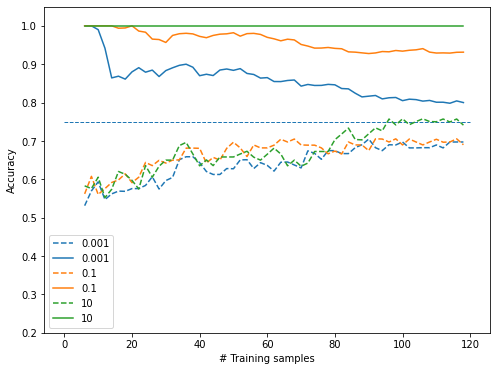

In [ ]:
fixed_parameters = {"solver" : "liblinear", "penalty" : "l2", "max_iter" : 3500, "tol" : 0.001,
                    "class_weight" : "balanced", "dual" : False, "fit_intercept" : True}

varying = [{"C" : 0.001},
           {"C" : 0.1},
           {"C" : 10}]

model = LogisticRegression

grid_search_lc(model, varying, fixed_parameters, x_complete_nostop,
               y_complete, 10, hline = [1, 0, 0], scoring_metric = "accuracy")

_ = plt.ylabel("Accuracy")
_ = plt.xlabel("# Training samples")
_ = plt.ylim(0.2, 1.05)
_ = plt.savefig("./logreg_overfit.png", dpi = 200)

## confusion matrix heatmap

Accuracy Score -> 71.42857142857143
Accuracy Score -> 78.57142857142857
Accuracy Score -> 69.23076923076923
Accuracy Score -> 61.53846153846154
Accuracy Score -> 84.61538461538461
Accuracy Score -> 69.23076923076923
Accuracy Score -> 61.53846153846154
Accuracy Score -> 61.53846153846154
Accuracy Score -> 46.15384615384615
Accuracy Score -> 69.23076923076923
Average accuracy over 10 folds: 67.3076923076923


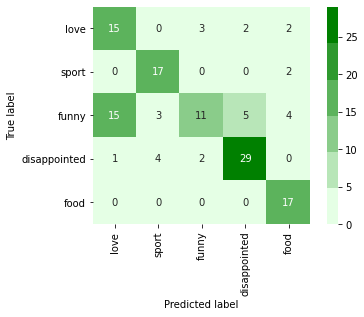

In [ ]:
params = {"solver" : "liblinear", "penalty" : "l2", "max_iter" : 3500, "tol" : 0.001,
          "C" : 0.001, "class_weight" : "balanced", "dual" : False, "fit_intercept" : True}
model = LogisticRegression(**params)
CV_heatmap(model, 10)

## create test prediction

In [ ]:
##################################################
# Save your test prediction in y_test_pred
##################################################
params = {"C" : 0.001, "solver" : "liblinear", "penalty" : "l2",
          "max_iter" : 3500, "tol" : 0.001, "class_weight" : "balanced",
          "dual" : False, "fit_intercept" : True}

transformer = StdTransformer()
transformer.fit(x_complete_nostop)
x_complete_nostop_trans = transformer.transform(x_complete_nostop)
x_test_transf = transformer.transform(x_test_nostop)

y_test_pred = LogisticRegression(**params).fit(
    x_complete_nostop_trans, y_complete).predict(x_test_transf)

# Create submission
submission = pd.read_csv(PATH_SUBMISSION)

if y_test_pred is not None:
    submission['class'] = y_test_pred
submission.to_csv('my_submission_logreg.csv', index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#SVM

## parameters grid

In [ ]:
# hyperparameters SVM:
# - Kernel: The main function of the kernel is to take low dimensional input space and transform it into a higher-dimensional space. 
# It is mostly useful in non-linear separation problem.

# - C: C is the penalty parameter, which represents misclassification or error term. 
# The misclassification or error term tells the SVM optimisation how much error is bearable. 
# This is how you can control the trade-off between decision boundary and misclassification term.
# The higher is C (the lower is lambda), the higher will be the number of examples of the training correctly classified.
# So, I will overfit. 

# Gamma: It defines how far influences the calculation of plausible line of separation.
# For high values of Gamma, only nearest point to the boundary are considered.
# For low values of Gamma, far away points are considered.



parameters_grid =[{'clf__kernel': ['rbf'],
                   'clf__gamma': [1e-4, 1e-3, 0.001, 0.01, 0.1, 'scale', 'auto'],
                   'clf__C': [0.01, 0.1, 1, 10, 100],
                   'clf__class_weight':[None, 'balanced']},
                  
                  {'clf__kernel': ['linear'], 
                   'clf__C': [0.01, 0.1, 1, 10, 100],
                   'clf__class_weight':[None, 'balanced']},
                  
                  {'clf__kernel': ['poly'], 
                   'clf__degree': [0.5, 1, 2, 3, 4, 5, 6], 
                   'clf__gamma': [1e-4, 1e-3, 0.001, 0.01, 0.1, 'scale', 'auto'],
                   'clf__coef0': [0.001, 0.005, 0.01, 0.1, 1, 10, 100], 
                   'clf__C': [0.01, 0.1, 1, 10, 100],
                   'clf__class_weight':[None, 'balanced']},
                  
                  {'clf__kernel': ['sigmoid'], 
                   'clf__coef0': [0.001, 0.005, 0.01, 0.1, 1, 10, 100],
                   'clf__gamma': [1e-4, 1e-3, 0.001, 0.01, 0.1, 'scale', 'auto'],
                   'clf__C': [0.01, 0.1, 1, 10, 100],
                   'clf__class_weight':[None, 'balanced']}]

## grid search

In [ ]:
# grid search using pipeline

pipe_list = [('Std_trans', StdTransformer()), ('clf', svm.SVC())]
pipe = Pipeline(pipe_list)

In [ ]:
stratCV = StratifiedKFold(n_splits = 10, shuffle = True)

clf_svm = GridSearchCV(pipe, parameters_grid, cv = stratCV, return_train_score = 1)
clf_svm.fit(x_complete_nostop, y_complete)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('Std_trans', StdTransformer()),
                                       ('clf',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=Non...
                          'clf__gamma': [0.0001, 0.001, 0.001, 0.01, 0.1,
                                         'scale', 'auto'],
                          'clf__kernel': ['poly']

## dataframe SVM

In [ ]:
# creating a dataframe with grid search results for easier interpretation
grid_search_df = pd.DataFrame(columns=["Balanced","CV Acc. test mean", "CV Acc. train mean",
                                       "CV Acc. difference",
                                       "CV Acc. test std", "CV Acc. train std", "C",
                                       "r", "gamma", "degree", "kernel"])
grid_search_df["CV Acc. test mean"] = clf_svm.cv_results_['mean_test_score']
grid_search_df["CV Acc. test std"] = clf_svm.cv_results_['std_test_score']
grid_search_df["CV Acc. train mean"] = clf_svm.cv_results_['mean_train_score']
grid_search_df["CV Acc. train std"] = clf_svm.cv_results_['std_train_score']
grid_search_df["CV Acc. difference"] = np.abs(
    grid_search_df["CV Acc. test mean"] - grid_search_df["CV Acc. train mean"])

balanced_list = []
C_list = []
r_list = []
gammas = []
degree_list = []
kernel_list = []

# unpacking parmeters dictionary
for param_dict in clf_svm.cv_results_["params"]:
  C_list.append(param_dict["clf__C"])
  kernel_list.append(param_dict["clf__kernel"])
  balanced_list.append(param_dict["clf__class_weight"])


  if "clf__gamma" in param_dict:
    gammas.append(param_dict["clf__gamma"])
  else:
    gammas.append(None)

  if "clf__coef0" in param_dict:
    r_list.append(param_dict["clf__coef0"])
  else:
    r_list.append(None)

  if "clf__degree" in param_dict:
    degree_list.append(param_dict["clf__degree"])
  else:
    degree_list.append(None)

grid_search_df["Balanced"] = balanced_list
grid_search_df["C"] = C_list
grid_search_df["kernel"] = kernel_list
grid_search_df["gamma"] = gammas
grid_search_df["r"] = r_list
grid_search_df["degree"] = degree_list

In [ ]:
grid_search_df.sort_values(["CV Acc. difference", "CV Acc. test mean"],
                           ascending = [True, False])


,Balanced,CV Acc. test mean,CV Acc. train mean,CV Acc. difference,CV Acc. test std,CV Acc. train std,C,r,gamma,degree,kernel
3887,balanced,0.701648,0.845122,0.143473,0.123744,0.009279,10.0,1.0,auto,NaN,sigmoid
3838,None,0.708791,0.862790,0.153999,0.157894,0.012535,10.0,1.0,auto,NaN,sigmoid


## model fitting - sigmoid

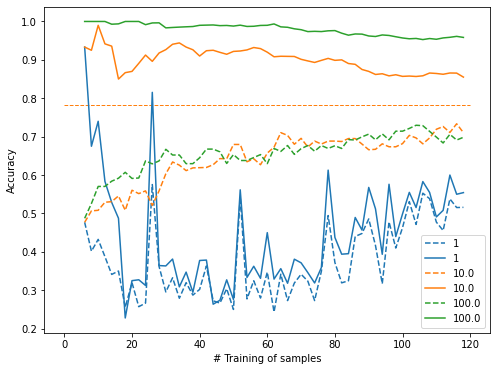

In [ ]:
# try to graphically represent the behaviour observed in the grid search
# observe overfitting and underfitting sigmoid
settings_list = [{"C" : 1},
                 {"C" : 1e1},
                 {"C" : 1e2}]
fixed_params = {"class_weight":'balanced', "kernel" : "sigmoid", "gamma" : "auto", "coef0" : 1}

model = svm.SVC

grid_search_lc(model, settings_list, fixed_params, x_complete_nostop,
               y_complete, 10, hline = [0, 1, 0], scoring_metric = "accuracy")

_ = plt.ylabel("Accuracy")
_ = plt.xlabel("# Training of samples")

_ = plt.savefig("./svm_overfit.png", dpi = 200)

## create test prediction

In [ ]:
##################################################
# Save your test prediction in y_test_pred
##################################################
params = {"class_weight":'balanced', "C":10, "kernel": "sigmoid", "gamma" : "auto", "coef0" : 1}
#underfitting params
#params = {"C" : 0.001, "kernel" : "poly", "degree" : 3, "gamma" : 1e-4, "coef0" : 100}

transformer = StdTransformer()
transformer.fit(x_complete_nostop)
x_complete_nostop_trans = transformer.transform(x_complete_nostop)
x_test_transf = transformer.transform(x_test_nostop)

y_test_pred = svm.SVC(**params).fit(x_complete_nostop_trans, y_complete).predict(x_test_transf)

# Create submission
submission = pd.read_csv(PATH_SUBMISSION)

if y_test_pred is not None:
    submission['class'] = y_test_pred
submission.to_csv('my_submission_svm.csv', index=False)

# FFNN

## parameters grids

In [ ]:
 ffnn_parameters_grid = [{ "size_hidden" : 150, "size_hidden_2" : None,
                          "learning_rate" : 1e-4, "reg_weight" : None},
                         { "size_hidden" : 100, "size_hidden_2" : None,
                          "learning_rate" : 1e-4, "reg_weight" : None},
                         { "size_hidden" : 50, "size_hidden_2" : None,
                          "learning_rate" : 1e-4, "reg_weight" : None}]

In [ ]:
grid_1_layer = [{ "size_hidden" : 150, "size_hidden_2" : None,
          "learning_rate" : 1e-4, "reg_weight" : None},
         { "size_hidden" : 100, "size_hidden_2" : None,
          "learning_rate" : 1e-4, "reg_weight" : None},
         { "size_hidden" : 50, "size_hidden_2" : None,
          "learning_rate" : 1e-4, "reg_weight" : None}
         ]

In [ ]:
grid_1_layer_reg = [{ "size_hidden" : 150, "size_hidden_2" : None,
          "learning_rate" : 1e-4, "reg_weight" : 1e-1},
         { "size_hidden" : 100, "size_hidden_2" : None,
          "learning_rate" : 1e-4, "reg_weight" : 1e-1},
         { "size_hidden" : 50, "size_hidden_2" : None,
          "learning_rate" : 1e-4, "reg_weight" : 1e-1}
         ]

In [ ]:
grid_2_layers = [{ "size_hidden" : 150, "size_hidden_2" : 150,
          "learning_rate" : 1e-4, "reg_weight" : None},
         { "size_hidden" : 150, "size_hidden_2" : 100,
          "learning_rate" : 1e-4, "reg_weight" : None},
         { "size_hidden" : 150, "size_hidden_2" : 50,
          "learning_rate" : 1e-4, "reg_weight" : None}
         ]

In [ ]:
grid_2_layers_reg = [{ "size_hidden" : 150, "size_hidden_2" : 150,
          "learning_rate" : 1e-4, "reg_weight" : 1e-1},
         { "size_hidden" : 150, "size_hidden_2" : 100,
          "learning_rate" : 1e-4, "reg_weight" : 1e-1},
         { "size_hidden" : 150, "size_hidden_2" : 50,
          "learning_rate" : 1e-4, "reg_weight" : 1e-1}
         ]

In [ ]:
grid_2_layers_reg_step = [{ "size_hidden" : 150, "size_hidden_2" : 50,
          "learning_rate" : 1e-2, "reg_weight" : 1e-1},
         { "size_hidden" : 150, "size_hidden_2" : 50,
          "learning_rate" : 1e-3, "reg_weight" : 1e-1},
         { "size_hidden" : 150, "size_hidden_2" : 50,
          "learning_rate" : 1e-4, "reg_weight" : 1e-1}
         ]

## grid search

In [ ]:
#First grid searh
df_gridsearch, train_loss, train_acc, val_loss, val_acc = \
  ffnn_gridsearch_cv(ffnn_parameters_grid, x_complete_nostop, 6, n_epochs = 200)

Training with 150-nodes 1st hidden layer and None-nodes 2nd hidden layer,
 0.0001 learning rate and None l2 regularization parameter
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Training with 100-nodes 1st hidden layer and None-nodes 2nd hidden layer,
 0.0001 learning rate and None l2 regularization parameter
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Training with 50-nodes 1st hidden layer and None-nodes 2nd hidden layer,
 0.0001 learning rate and None l2 regularization parameter
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [ ]:
#ONE HIDDEN LAYER no regularized
df_gridsearch_one_layer, train_loss, train_acc, val_loss, val_acc = \
  ffnn_gridsearch_cv(grid_1_layer, x_complete_nostop, 6, n_epochs = 200)

Training with 150-nodes 1st hidden layer and None-nodes 2nd hidden layer,
 0.0001 learning rate and None l2 regularization parameter
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Training with 100-nodes 1st hidden layer and None-nodes 2nd hidden layer,
 0.0001 learning rate and None l2 regularization parameter
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Training with 50-nodes 1st hidden layer and None-nodes 2nd hidden layer,
 0.0001 learning rate and None l2 regularization parameter
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [ ]:
#Two hidden layers no regularized
df_gridsearch_two_layers, train_loss, train_acc, val_loss, val_acc = \
  ffnn_gridsearch_cv(grid_2_layers, x_complete_nostop, 6, n_epochs = 200)

Training with 150-nodes 1st hidden layer and 150-nodes 2nd hidden layer,
 0.0001 learning rate and None l2 regularization parameter
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Training with 150-nodes 1st hidden layer and 100-nodes 2nd hidden layer,
 0.0001 learning rate and None l2 regularization parameter
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Training with 150-nodes 1st hidden layer and 50-nodes 2nd hidden layer,
 0.0001 learning rate and None l2 regularization parameter
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [ ]:
#Two hidden layers regularized
df_gridsearch_two_layers_regularized, train_loss, train_acc, val_loss, val_acc = \
  ffnn_gridsearch_cv(grid_2_layers_reg, x_complete_nostop, 6, n_epochs = 200)

Training with 150-nodes 1st hidden layer and 150-nodes 2nd hidden layer,
 0.0001 learning rate and 0.1 l2 regularization parameter
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Training with 150-nodes 1st hidden layer and 100-nodes 2nd hidden layer,
 0.0001 learning rate and 0.1 l2 regularization parameter
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Training with 150-nodes 1st hidden layer and 50-nodes 2nd hidden layer,
 0.0001 learning rate and 0.1 l2 regularization parameter
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [ ]:
# Two hidden layers regularized with different stepsize
df_gridsearch_stepsize, train_loss, train_acc, val_loss, val_acc = \
  ffnn_gridsearch_cv(grid_2_layers_reg_step, x_complete_nostop, 6, n_epochs = 200)

Training with 150-nodes 1st hidden layer and 50-nodes 2nd hidden layer,
 0.01 learning rate and 0.1 l2 regularization parameter
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Training with 150-nodes 1st hidden layer and 50-nodes 2nd hidden layer,
 0.001 learning rate and 0.1 l2 regularization parameter
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Training with 150-nodes 1st hidden layer and 50-nodes 2nd hidden layer,
 0.0001 learning rate and 0.1 l2 regularization parameter
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [ ]:
df_gridsearch.sort_values(["Diff. loss", "Avg. test accuracy"],
                           ascending = [True, False])

,Avg. train accuracy,Avg. test accuracy,Avg. train loss,Avg. test loss,Diff. loss,# nodes 1,# nodes 2,Stepsize,l2
2,0.809726,0.809973,0.180139,0.922163,0.742024,50,None,0.0001,None
1,0.864122,0.864279,0.111703,0.862838,0.751135,100,None,0.0001,None
0,0.884851,0.884946,0.079029,0.984952,0.905923,150,None,0.0001,None


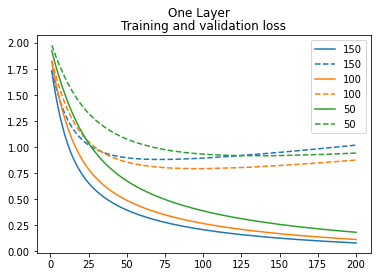

In [ ]:
labels = [(150), (100), (50)]

for i in range(len(df_gridsearch_one_layer.index)):
    plot_cv_history(train_acc[i], val_acc[i], train_loss[i], val_loss[i],
                  i, param_label = labels[i], loss = 1)
    
#plt.ylim(0, 2)
_ = plt.suptitle("One Layer")
#_ = plt.savefig("./ffnn_1lay_loss.png")

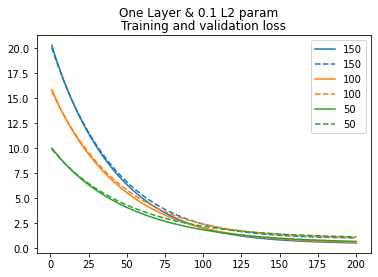

In [ ]:
labels = [(150), (100), (50)]

for i in range(len(df_gridsearch.index)):
    plot_cv_history(train_acc[i], val_acc[i], train_loss[i], val_loss[i],
                  i, param_label = labels[i], loss = 1)
    
#plt.ylim(0, 5)
_ = plt.suptitle("One Layer & 0.1 L2 param")
#_=plt.savefig("./ffnn_1lay_reg_loss.png", dpi = 200)

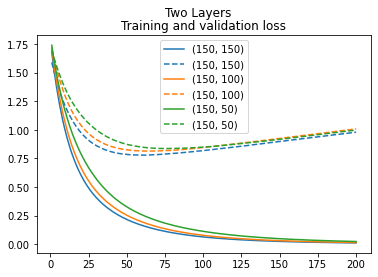

In [ ]:
#TWO LAYERS non regularized: LOSS
labels = [(150, 150), (150, 100), (150, 50)]

for i in range(len(df_gridsearch_two_layers.index)):
    plot_cv_history(train_acc[i], val_acc[i], train_loss[i], val_loss[i],
                  i, param_label = labels[i], loss = 1)
    
#plt.ylim(0, 2)
_ = plt.suptitle("Two Layers")
#_ = plt.savefig("./ffnn_2lay_acc.png", dpi = 200)

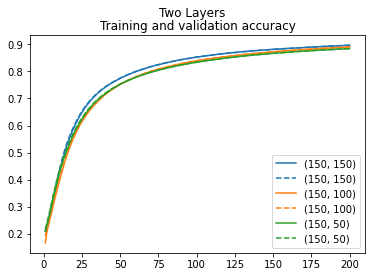

In [ ]:
#TWO LAYERS non regularized: ACCURACY
labels = [(150, 150), (150, 100), (150, 50)]

for i in range(len(df_gridsearch_two_layers.index)):
    plot_cv_history(train_acc[i], val_acc[i], train_loss[i], val_loss[i],
                  i, param_label = labels[i], loss = 0)
    
#plt.ylim(0, 2)
_ = plt.suptitle("Two Layers")
#_ = plt.savefig("./ffnn_2lay_acc.png", dpi = 200)

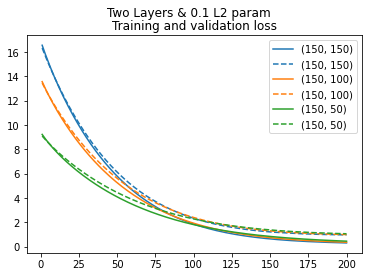

In [ ]:
#TWO LAYERS REGULARIZED: LOSS
labels = [(150, 150), (150, 100), (150, 50)]

for i in range(len(df_gridsearch_two_layers_regularized.index)):
    plot_cv_history(train_acc[i], val_acc[i], train_loss[i], val_loss[i],
                  i, param_label = labels[i], loss = 1)
    
#plt.ylim(0, 5)
_ = plt.suptitle("Two Layers & 0.1 L2 param")
#_ = plt.savefig("./ffnn_2lay_reg_acc.png", dpi = 200)


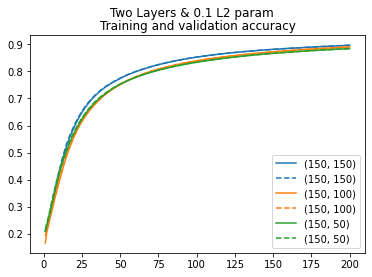

In [ ]:
#TWO LAYERS REGULARIZED: ACCURACY
labels = [(150, 150), (150, 100), (150, 50)]

for i in range(len(df_gridsearch_two_layers_regularized.index)):
    plot_cv_history(train_acc[i], val_acc[i], train_loss[i], val_loss[i],
                  i, param_label = labels[i], loss = 0)
    
#plt.ylim(0, 5)
_ = plt.suptitle("Two Layers & 0.1 L2 param")
#_ = plt.savefig("./ffnn_2lay_reg_acc.png", dpi = 200)

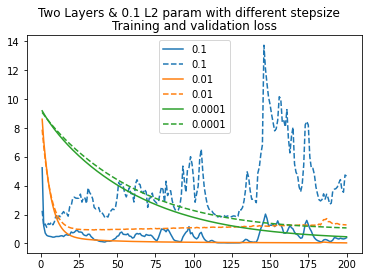

In [ ]:
#STEP-SIZE
labels = [1e-1,1e-2,1e-4]

for i in range(len(df_gridsearch_stepsize.index)):
    plot_cv_history(train_acc[i], val_acc[i], train_loss[i], val_loss[i],
                  i, param_label = labels[i], loss = 1)
    
_ = plt.suptitle("Two Layers & 0.1 L2 param with different stepsize")
#_ = plt.savefig("./ffnn_2lay_reg_acc.png", dpi = 200)

## create test prediction

In [ ]:
##################################################
# Save your test prediction in y_test_pred
##################################################
transformer = StdTransformer()

# transform train and validation data to standardized form
transformer.fit(x_complete_nostop)
x_complete_transf = transformer.transform(x_complete_nostop)
x_test_transf = transformer.transform(x_test_nostop)

# transform y_validation in one-hot version
y_complete_1h = tf.keras.utils.to_categorical(y_complete, 5)

ff_nn = create_ff_model2(150,50,0.1)

ff_nn.fit(x_complete_transf, y_complete_1h,
          batch_size = 6, epochs = 200, verbose = False)

y_test_pred = ff_nn.predict(x_test_transf)

y_test_pred = np.argmax(y_test_pred, axis = 1)

# Create submission
submission = pd.read_csv(PATH_SUBMISSION)

if y_test_pred is not None:
    submission['class'] = y_test_pred
submission.to_csv('my_submission_ffnn.csv', index=False)